# Federated Learning Simple Implementation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [2]:
epoch = 10
rounds = 25
num_clients = 10

clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size =128
eval_batch_size=256
quantize_bits = 3
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [3]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified



- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

In [4]:

def server_aggregate(global_model : torch.nn.Module, client_models):
    """
    The means of the weights of the client models are aggregated to the global model
    """
    global_dict = global_model.state_dict() # Get a copy of the global model state_dict
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))],0).mean(0)
    global_model.load_state_dict(global_dict)
    
    # Update the client models using the global model
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [5]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]



# criterion = nn.CrossEntropyLoss() # computes the cross-entropy loss between the predicted and true labels
# optimizers =[optim.Adam(model.parameters(), lr=0.001) for model in client_models]


In [6]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=0.1,
                                       weight_decay=5e-4)

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120,160], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

optimizers = [get_model_optimizer(model,learning_rate=0.1, weight_decay=5e-4) for model in client_models]

In [7]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer

        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate
    server_aggregate(global_model, client_models)

    # Test the global model
    test_loss, test_acc = evaluate_model(model=global_model,
                                         test_loader=test_loader,
                                         device=device,
                                         criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0/10 Train Loss: 2.843 Train Acc: 0.163
Epoch: 1/10 Train Loss: 2.157 Train Acc: 0.200
Epoch: 2/10 Train Loss: 1.980 Train Acc: 0.252
Epoch: 3/10 Train Loss: 1.919 Train Acc: 0.274
Epoch: 4/10 Train Loss: 1.916 Train Acc: 0.276
Epoch: 5/10 Train Loss: 1.916 Train Acc: 0.282
Epoch: 6/10 Train Loss: 1.909 Train Acc: 0.287
Epoch: 7/10 Train Loss: 1.916 Train Acc: 0.280
Epoch: 8/10 Train Loss: 1.907 Train Acc: 0.274
Epoch: 9/10 Train Loss: 1.907 Train Acc: 0.286
Epoch: 0/10 Train Loss: 3.159 Train Acc: 0.147
Epoch: 1/10 Train Loss: 2.323 Train Acc: 0.179
Epoch: 2/10 Train Loss: 2.033 Train Acc: 0.230
Epoch: 3/10 Train Loss: 1.998 Train Acc: 0.239
Epoch: 4/10 Train Loss: 1.983 Train Acc: 0.256
Epoch: 5/10 Train Loss: 1.984 Train Acc: 0.246
Epoch: 6/10 Train Loss: 1.987 Train Acc: 0.252
Epoch: 7/10 Train Loss: 1.985 Train Acc: 0.248
Epoch: 8/10 Train Loss: 1.990 Train Acc: 0.252
Epoch: 9/10 Train Loss: 1.989 Train Acc: 0.254
Epoch: 0/10 Train Loss: 3.112 Train Acc: 0.123
Epoch: 1/10 T

  4%|▍         | 1/25 [05:29<2:11:47, 329.49s/it]

0-th ROUND: average train loss 0.664 | test loss 2.3 | test acc: 0.100
Epoch: 0/10 Train Loss: 2.164 Train Acc: 0.187
Epoch: 1/10 Train Loss: 2.008 Train Acc: 0.241
Epoch: 2/10 Train Loss: 1.892 Train Acc: 0.280
Epoch: 3/10 Train Loss: 1.832 Train Acc: 0.312
Epoch: 4/10 Train Loss: 1.825 Train Acc: 0.313
Epoch: 5/10 Train Loss: 1.814 Train Acc: 0.324
Epoch: 6/10 Train Loss: 1.822 Train Acc: 0.316
Epoch: 7/10 Train Loss: 1.825 Train Acc: 0.321
Epoch: 8/10 Train Loss: 1.823 Train Acc: 0.319
Epoch: 9/10 Train Loss: 1.816 Train Acc: 0.317
Epoch: 0/10 Train Loss: 2.336 Train Acc: 0.112
Epoch: 1/10 Train Loss: 2.277 Train Acc: 0.125
Epoch: 2/10 Train Loss: 2.241 Train Acc: 0.153
Epoch: 3/10 Train Loss: 2.236 Train Acc: 0.163
Epoch: 4/10 Train Loss: 2.235 Train Acc: 0.164
Epoch: 5/10 Train Loss: 2.236 Train Acc: 0.168
Epoch: 6/10 Train Loss: 2.236 Train Acc: 0.168
Epoch: 7/10 Train Loss: 2.237 Train Acc: 0.159
Epoch: 8/10 Train Loss: 2.235 Train Acc: 0.166
Epoch: 9/10 Train Loss: 2.237 Train 

  8%|▊         | 2/25 [10:44<2:03:07, 321.20s/it]

1-th ROUND: average train loss 0.602 | test loss 2.31 | test acc: 0.100
Epoch: 0/10 Train Loss: 2.059 Train Acc: 0.215
Epoch: 1/10 Train Loss: 2.016 Train Acc: 0.237
Epoch: 2/10 Train Loss: 1.997 Train Acc: 0.246
Epoch: 3/10 Train Loss: 2.000 Train Acc: 0.245
Epoch: 4/10 Train Loss: 2.000 Train Acc: 0.239
Epoch: 5/10 Train Loss: 2.000 Train Acc: 0.240
Epoch: 6/10 Train Loss: 2.002 Train Acc: 0.240
Epoch: 7/10 Train Loss: 1.996 Train Acc: 0.247
Epoch: 8/10 Train Loss: 1.999 Train Acc: 0.243
Epoch: 9/10 Train Loss: 2.000 Train Acc: 0.246
Epoch: 0/10 Train Loss: 2.053 Train Acc: 0.218
Epoch: 1/10 Train Loss: 2.015 Train Acc: 0.238
Epoch: 2/10 Train Loss: 1.997 Train Acc: 0.247
Epoch: 3/10 Train Loss: 1.998 Train Acc: 0.245
Epoch: 4/10 Train Loss: 1.995 Train Acc: 0.250
Epoch: 5/10 Train Loss: 1.998 Train Acc: 0.243
Epoch: 6/10 Train Loss: 1.996 Train Acc: 0.248
Epoch: 7/10 Train Loss: 1.998 Train Acc: 0.251
Epoch: 8/10 Train Loss: 1.996 Train Acc: 0.244
Epoch: 9/10 Train Loss: 1.998 Train

 12%|█▏        | 3/25 [15:59<1:56:42, 318.30s/it]

2-th ROUND: average train loss 0.578 | test loss 2.31 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.941 Train Acc: 0.268
Epoch: 1/10 Train Loss: 1.919 Train Acc: 0.281
Epoch: 2/10 Train Loss: 1.908 Train Acc: 0.282
Epoch: 3/10 Train Loss: 1.909 Train Acc: 0.292
Epoch: 4/10 Train Loss: 1.909 Train Acc: 0.287
Epoch: 5/10 Train Loss: 1.910 Train Acc: 0.287
Epoch: 6/10 Train Loss: 1.908 Train Acc: 0.290
Epoch: 7/10 Train Loss: 1.908 Train Acc: 0.290
Epoch: 8/10 Train Loss: 1.913 Train Acc: 0.290
Epoch: 9/10 Train Loss: 1.912 Train Acc: 0.286
Epoch: 0/10 Train Loss: 1.984 Train Acc: 0.246
Epoch: 1/10 Train Loss: 1.977 Train Acc: 0.253
Epoch: 2/10 Train Loss: 1.933 Train Acc: 0.273
Epoch: 3/10 Train Loss: 1.798 Train Acc: 0.326
Epoch: 4/10 Train Loss: 1.785 Train Acc: 0.331
Epoch: 5/10 Train Loss: 1.782 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.783 Train Acc: 0.339
Epoch: 7/10 Train Loss: 1.789 Train Acc: 0.338
Epoch: 8/10 Train Loss: 1.784 Train Acc: 0.336
Epoch: 9/10 Train Loss: 1.780 Train

 16%|█▌        | 4/25 [21:14<1:50:53, 316.84s/it]

3-th ROUND: average train loss 0.637 | test loss 2.31 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.945 Train Acc: 0.252
Epoch: 1/10 Train Loss: 2.062 Train Acc: 0.233
Epoch: 2/10 Train Loss: 1.885 Train Acc: 0.298
Epoch: 3/10 Train Loss: 1.798 Train Acc: 0.333
Epoch: 4/10 Train Loss: 1.783 Train Acc: 0.346
Epoch: 5/10 Train Loss: 1.773 Train Acc: 0.343
Epoch: 6/10 Train Loss: 1.771 Train Acc: 0.347
Epoch: 7/10 Train Loss: 1.773 Train Acc: 0.345
Epoch: 8/10 Train Loss: 1.774 Train Acc: 0.345
Epoch: 9/10 Train Loss: 1.777 Train Acc: 0.340
Epoch: 0/10 Train Loss: 1.885 Train Acc: 0.290
Epoch: 1/10 Train Loss: 1.874 Train Acc: 0.296
Epoch: 2/10 Train Loss: 1.864 Train Acc: 0.308
Epoch: 3/10 Train Loss: 1.874 Train Acc: 0.302
Epoch: 4/10 Train Loss: 1.867 Train Acc: 0.293
Epoch: 5/10 Train Loss: 1.873 Train Acc: 0.298
Epoch: 6/10 Train Loss: 1.876 Train Acc: 0.296
Epoch: 7/10 Train Loss: 1.867 Train Acc: 0.298
Epoch: 8/10 Train Loss: 1.872 Train Acc: 0.305
Epoch: 9/10 Train Loss: 1.871 Train

 20%|██        | 5/25 [26:29<1:45:24, 316.24s/it]

4-th ROUND: average train loss 0.567 | test loss 2.31 | test acc: 0.097
Epoch: 0/10 Train Loss: 1.836 Train Acc: 0.317
Epoch: 1/10 Train Loss: 1.833 Train Acc: 0.318
Epoch: 2/10 Train Loss: 1.832 Train Acc: 0.315
Epoch: 3/10 Train Loss: 1.838 Train Acc: 0.317
Epoch: 4/10 Train Loss: 1.839 Train Acc: 0.315
Epoch: 5/10 Train Loss: 1.838 Train Acc: 0.319
Epoch: 6/10 Train Loss: 1.832 Train Acc: 0.317
Epoch: 7/10 Train Loss: 1.839 Train Acc: 0.310
Epoch: 8/10 Train Loss: 1.840 Train Acc: 0.315
Epoch: 9/10 Train Loss: 1.839 Train Acc: 0.316
Epoch: 0/10 Train Loss: 1.842 Train Acc: 0.316
Epoch: 1/10 Train Loss: 1.834 Train Acc: 0.325
Epoch: 2/10 Train Loss: 1.834 Train Acc: 0.324
Epoch: 3/10 Train Loss: 1.832 Train Acc: 0.317
Epoch: 4/10 Train Loss: 1.834 Train Acc: 0.315
Epoch: 5/10 Train Loss: 1.833 Train Acc: 0.319
Epoch: 6/10 Train Loss: 1.827 Train Acc: 0.326
Epoch: 7/10 Train Loss: 1.825 Train Acc: 0.324
Epoch: 8/10 Train Loss: 1.828 Train Acc: 0.329
Epoch: 9/10 Train Loss: 1.831 Train

 24%|██▍       | 6/25 [31:45<1:40:04, 316.00s/it]

5-th ROUND: average train loss 0.615 | test loss 2.32 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.852 Train Acc: 0.317
Epoch: 1/10 Train Loss: 1.849 Train Acc: 0.311
Epoch: 2/10 Train Loss: 1.851 Train Acc: 0.318
Epoch: 3/10 Train Loss: 1.849 Train Acc: 0.316
Epoch: 4/10 Train Loss: 1.844 Train Acc: 0.317
Epoch: 5/10 Train Loss: 1.848 Train Acc: 0.313
Epoch: 6/10 Train Loss: 1.851 Train Acc: 0.314
Epoch: 7/10 Train Loss: 1.851 Train Acc: 0.312
Epoch: 8/10 Train Loss: 1.855 Train Acc: 0.316
Epoch: 9/10 Train Loss: 1.851 Train Acc: 0.312
Epoch: 0/10 Train Loss: 1.843 Train Acc: 0.311
Epoch: 1/10 Train Loss: 1.832 Train Acc: 0.321
Epoch: 2/10 Train Loss: 1.828 Train Acc: 0.318
Epoch: 3/10 Train Loss: 1.828 Train Acc: 0.318
Epoch: 4/10 Train Loss: 1.825 Train Acc: 0.315
Epoch: 5/10 Train Loss: 1.826 Train Acc: 0.320
Epoch: 6/10 Train Loss: 1.827 Train Acc: 0.322
Epoch: 7/10 Train Loss: 1.828 Train Acc: 0.322
Epoch: 8/10 Train Loss: 1.827 Train Acc: 0.315
Epoch: 9/10 Train Loss: 1.819 Train

 28%|██▊       | 7/25 [36:59<1:34:41, 315.62s/it]

6-th ROUND: average train loss 0.613 | test loss 2.33 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.832 Train Acc: 0.314
Epoch: 1/10 Train Loss: 1.828 Train Acc: 0.319
Epoch: 2/10 Train Loss: 1.830 Train Acc: 0.319
Epoch: 3/10 Train Loss: 1.838 Train Acc: 0.317
Epoch: 4/10 Train Loss: 1.826 Train Acc: 0.325
Epoch: 5/10 Train Loss: 1.835 Train Acc: 0.314
Epoch: 6/10 Train Loss: 1.837 Train Acc: 0.312
Epoch: 7/10 Train Loss: 1.825 Train Acc: 0.320
Epoch: 8/10 Train Loss: 1.833 Train Acc: 0.317
Epoch: 9/10 Train Loss: 1.830 Train Acc: 0.314
Epoch: 0/10 Train Loss: 1.841 Train Acc: 0.320
Epoch: 1/10 Train Loss: 1.846 Train Acc: 0.315
Epoch: 2/10 Train Loss: 1.844 Train Acc: 0.312
Epoch: 3/10 Train Loss: 1.839 Train Acc: 0.318
Epoch: 4/10 Train Loss: 1.842 Train Acc: 0.313
Epoch: 5/10 Train Loss: 1.842 Train Acc: 0.312
Epoch: 6/10 Train Loss: 1.842 Train Acc: 0.315
Epoch: 7/10 Train Loss: 1.843 Train Acc: 0.312
Epoch: 8/10 Train Loss: 1.850 Train Acc: 0.313
Epoch: 9/10 Train Loss: 1.846 Train

 32%|███▏      | 8/25 [42:15<1:29:23, 315.48s/it]

7-th ROUND: average train loss 0.613 | test loss 2.34 | test acc: 0.100
Epoch: 0/10 Train Loss: 1.887 Train Acc: 0.290
Epoch: 1/10 Train Loss: 1.861 Train Acc: 0.297
Epoch: 2/10 Train Loss: 1.777 Train Acc: 0.320
Epoch: 3/10 Train Loss: 1.671 Train Acc: 0.380
Epoch: 4/10 Train Loss: 1.659 Train Acc: 0.381
Epoch: 5/10 Train Loss: 1.655 Train Acc: 0.384
Epoch: 6/10 Train Loss: 1.647 Train Acc: 0.392
Epoch: 7/10 Train Loss: 1.664 Train Acc: 0.381
Epoch: 8/10 Train Loss: 1.663 Train Acc: 0.377
Epoch: 9/10 Train Loss: 1.649 Train Acc: 0.397
Epoch: 0/10 Train Loss: 1.844 Train Acc: 0.311
Epoch: 1/10 Train Loss: 1.846 Train Acc: 0.314
Epoch: 2/10 Train Loss: 1.848 Train Acc: 0.317
Epoch: 3/10 Train Loss: 1.845 Train Acc: 0.322
Epoch: 4/10 Train Loss: 1.851 Train Acc: 0.307
Epoch: 5/10 Train Loss: 1.855 Train Acc: 0.306
Epoch: 6/10 Train Loss: 1.846 Train Acc: 0.314
Epoch: 7/10 Train Loss: 1.845 Train Acc: 0.311
Epoch: 8/10 Train Loss: 1.849 Train Acc: 0.313
Epoch: 9/10 Train Loss: 1.848 Train

 36%|███▌      | 9/25 [47:29<1:24:04, 315.27s/it]

8-th ROUND: average train loss 0.615 | test loss 2.35 | test acc: 0.101
Epoch: 0/10 Train Loss: 1.796 Train Acc: 0.335
Epoch: 1/10 Train Loss: 1.798 Train Acc: 0.327
Epoch: 2/10 Train Loss: 1.797 Train Acc: 0.329
Epoch: 3/10 Train Loss: 1.795 Train Acc: 0.330
Epoch: 4/10 Train Loss: 1.794 Train Acc: 0.328
Epoch: 5/10 Train Loss: 1.794 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.799 Train Acc: 0.331
Epoch: 7/10 Train Loss: 1.796 Train Acc: 0.335
Epoch: 8/10 Train Loss: 1.792 Train Acc: 0.335
Epoch: 9/10 Train Loss: 1.797 Train Acc: 0.335
Epoch: 0/10 Train Loss: 1.787 Train Acc: 0.334
Epoch: 1/10 Train Loss: 1.773 Train Acc: 0.337
Epoch: 2/10 Train Loss: 1.770 Train Acc: 0.333
Epoch: 3/10 Train Loss: 1.766 Train Acc: 0.331
Epoch: 4/10 Train Loss: 1.767 Train Acc: 0.339
Epoch: 5/10 Train Loss: 1.770 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.763 Train Acc: 0.340
Epoch: 7/10 Train Loss: 1.766 Train Acc: 0.347
Epoch: 8/10 Train Loss: 1.763 Train Acc: 0.341
Epoch: 9/10 Train Loss: 1.775 Train

 40%|████      | 10/25 [52:44<1:18:48, 315.21s/it]

9-th ROUND: average train loss 0.599 | test loss 2.31 | test acc: 0.111
Epoch: 0/10 Train Loss: 1.787 Train Acc: 0.332
Epoch: 1/10 Train Loss: 1.788 Train Acc: 0.336
Epoch: 2/10 Train Loss: 1.791 Train Acc: 0.337
Epoch: 3/10 Train Loss: 1.799 Train Acc: 0.325
Epoch: 4/10 Train Loss: 1.790 Train Acc: 0.334
Epoch: 5/10 Train Loss: 1.790 Train Acc: 0.338
Epoch: 6/10 Train Loss: 1.794 Train Acc: 0.332
Epoch: 7/10 Train Loss: 1.785 Train Acc: 0.335
Epoch: 8/10 Train Loss: 1.784 Train Acc: 0.334
Epoch: 9/10 Train Loss: 1.793 Train Acc: 0.333
Epoch: 0/10 Train Loss: 1.800 Train Acc: 0.333
Epoch: 1/10 Train Loss: 1.806 Train Acc: 0.329
Epoch: 2/10 Train Loss: 1.805 Train Acc: 0.335
Epoch: 3/10 Train Loss: 1.805 Train Acc: 0.329
Epoch: 4/10 Train Loss: 1.804 Train Acc: 0.331
Epoch: 5/10 Train Loss: 1.804 Train Acc: 0.331
Epoch: 6/10 Train Loss: 1.802 Train Acc: 0.333
Epoch: 7/10 Train Loss: 1.803 Train Acc: 0.341
Epoch: 8/10 Train Loss: 1.808 Train Acc: 0.328
Epoch: 9/10 Train Loss: 1.802 Train

 44%|████▍     | 11/25 [57:59<1:13:30, 315.05s/it]

10-th ROUND: average train loss 0.6 | test loss 2.23 | test acc: 0.137
Epoch: 0/10 Train Loss: 1.801 Train Acc: 0.328
Epoch: 1/10 Train Loss: 1.793 Train Acc: 0.339
Epoch: 2/10 Train Loss: 1.806 Train Acc: 0.326
Epoch: 3/10 Train Loss: 1.798 Train Acc: 0.329
Epoch: 4/10 Train Loss: 1.799 Train Acc: 0.331
Epoch: 5/10 Train Loss: 1.804 Train Acc: 0.328
Epoch: 6/10 Train Loss: 1.806 Train Acc: 0.325
Epoch: 7/10 Train Loss: 1.797 Train Acc: 0.330
Epoch: 8/10 Train Loss: 1.799 Train Acc: 0.321
Epoch: 9/10 Train Loss: 1.790 Train Acc: 0.335
Epoch: 0/10 Train Loss: 1.813 Train Acc: 0.322
Epoch: 1/10 Train Loss: 1.805 Train Acc: 0.323
Epoch: 2/10 Train Loss: 1.802 Train Acc: 0.327
Epoch: 3/10 Train Loss: 1.806 Train Acc: 0.323
Epoch: 4/10 Train Loss: 1.802 Train Acc: 0.331
Epoch: 5/10 Train Loss: 1.811 Train Acc: 0.328
Epoch: 6/10 Train Loss: 1.807 Train Acc: 0.325
Epoch: 7/10 Train Loss: 1.805 Train Acc: 0.331
Epoch: 8/10 Train Loss: 1.798 Train Acc: 0.331
Epoch: 9/10 Train Loss: 1.809 Train 

 48%|████▊     | 12/25 [1:03:14<1:08:16, 315.13s/it]

11-th ROUND: average train loss 0.595 | test loss 2.11 | test acc: 0.194
Epoch: 0/10 Train Loss: 1.803 Train Acc: 0.326
Epoch: 1/10 Train Loss: 1.798 Train Acc: 0.339
Epoch: 2/10 Train Loss: 1.800 Train Acc: 0.331
Epoch: 3/10 Train Loss: 1.804 Train Acc: 0.327
Epoch: 4/10 Train Loss: 1.801 Train Acc: 0.330
Epoch: 5/10 Train Loss: 1.804 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.800 Train Acc: 0.338
Epoch: 7/10 Train Loss: 1.807 Train Acc: 0.333
Epoch: 8/10 Train Loss: 1.802 Train Acc: 0.335
Epoch: 9/10 Train Loss: 1.806 Train Acc: 0.333
Epoch: 0/10 Train Loss: 1.795 Train Acc: 0.335
Epoch: 1/10 Train Loss: 1.792 Train Acc: 0.340
Epoch: 2/10 Train Loss: 1.793 Train Acc: 0.328
Epoch: 3/10 Train Loss: 1.792 Train Acc: 0.334
Epoch: 4/10 Train Loss: 1.792 Train Acc: 0.336
Epoch: 5/10 Train Loss: 1.795 Train Acc: 0.331
Epoch: 6/10 Train Loss: 1.798 Train Acc: 0.328
Epoch: 7/10 Train Loss: 1.797 Train Acc: 0.336
Epoch: 8/10 Train Loss: 1.799 Train Acc: 0.330
Epoch: 9/10 Train Loss: 1.796 Trai

 52%|█████▏    | 13/25 [1:08:30<1:03:02, 315.20s/it]

12-th ROUND: average train loss 0.598 | test loss 2 | test acc: 0.262
Epoch: 0/10 Train Loss: 1.786 Train Acc: 0.337
Epoch: 1/10 Train Loss: 1.794 Train Acc: 0.328
Epoch: 2/10 Train Loss: 1.793 Train Acc: 0.330
Epoch: 3/10 Train Loss: 1.788 Train Acc: 0.332
Epoch: 4/10 Train Loss: 1.789 Train Acc: 0.331
Epoch: 5/10 Train Loss: 1.791 Train Acc: 0.332
Epoch: 6/10 Train Loss: 1.788 Train Acc: 0.325
Epoch: 7/10 Train Loss: 1.792 Train Acc: 0.334
Epoch: 8/10 Train Loss: 1.782 Train Acc: 0.337
Epoch: 9/10 Train Loss: 1.792 Train Acc: 0.333
Epoch: 0/10 Train Loss: 1.800 Train Acc: 0.328
Epoch: 1/10 Train Loss: 1.798 Train Acc: 0.329
Epoch: 2/10 Train Loss: 1.797 Train Acc: 0.333
Epoch: 3/10 Train Loss: 1.804 Train Acc: 0.329
Epoch: 4/10 Train Loss: 1.812 Train Acc: 0.323
Epoch: 5/10 Train Loss: 1.807 Train Acc: 0.329
Epoch: 6/10 Train Loss: 1.800 Train Acc: 0.337
Epoch: 7/10 Train Loss: 1.802 Train Acc: 0.338
Epoch: 8/10 Train Loss: 1.800 Train Acc: 0.337
Epoch: 9/10 Train Loss: 1.796 Train A

 56%|█████▌    | 14/25 [1:13:45<57:45, 315.07s/it]  

13-th ROUND: average train loss 0.603 | test loss 1.9 | test acc: 0.309
Epoch: 0/10 Train Loss: 1.799 Train Acc: 0.324
Epoch: 1/10 Train Loss: 1.800 Train Acc: 0.327
Epoch: 2/10 Train Loss: 1.801 Train Acc: 0.323
Epoch: 3/10 Train Loss: 1.800 Train Acc: 0.326
Epoch: 4/10 Train Loss: 1.801 Train Acc: 0.331
Epoch: 5/10 Train Loss: 1.799 Train Acc: 0.320
Epoch: 6/10 Train Loss: 1.798 Train Acc: 0.325
Epoch: 7/10 Train Loss: 1.798 Train Acc: 0.330
Epoch: 8/10 Train Loss: 1.806 Train Acc: 0.328
Epoch: 9/10 Train Loss: 1.795 Train Acc: 0.329
Epoch: 0/10 Train Loss: 1.775 Train Acc: 0.329
Epoch: 1/10 Train Loss: 1.780 Train Acc: 0.328
Epoch: 2/10 Train Loss: 1.786 Train Acc: 0.332
Epoch: 3/10 Train Loss: 1.779 Train Acc: 0.333
Epoch: 4/10 Train Loss: 1.785 Train Acc: 0.334
Epoch: 5/10 Train Loss: 1.778 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.782 Train Acc: 0.332
Epoch: 7/10 Train Loss: 1.782 Train Acc: 0.335
Epoch: 8/10 Train Loss: 1.784 Train Acc: 0.334
Epoch: 9/10 Train Loss: 1.779 Train

 60%|██████    | 15/25 [1:19:00<52:31, 315.16s/it]

14-th ROUND: average train loss 0.6 | test loss 1.84 | test acc: 0.335
Epoch: 0/10 Train Loss: 1.802 Train Acc: 0.328
Epoch: 1/10 Train Loss: 1.804 Train Acc: 0.323
Epoch: 2/10 Train Loss: 1.805 Train Acc: 0.323
Epoch: 3/10 Train Loss: 1.803 Train Acc: 0.329
Epoch: 4/10 Train Loss: 1.803 Train Acc: 0.334
Epoch: 5/10 Train Loss: 1.807 Train Acc: 0.322
Epoch: 6/10 Train Loss: 1.802 Train Acc: 0.329
Epoch: 7/10 Train Loss: 1.803 Train Acc: 0.325
Epoch: 8/10 Train Loss: 1.802 Train Acc: 0.325
Epoch: 9/10 Train Loss: 1.802 Train Acc: 0.330
Epoch: 0/10 Train Loss: 1.805 Train Acc: 0.330
Epoch: 1/10 Train Loss: 1.799 Train Acc: 0.336
Epoch: 2/10 Train Loss: 1.802 Train Acc: 0.331
Epoch: 3/10 Train Loss: 1.799 Train Acc: 0.336
Epoch: 4/10 Train Loss: 1.800 Train Acc: 0.338
Epoch: 5/10 Train Loss: 1.801 Train Acc: 0.333
Epoch: 6/10 Train Loss: 1.798 Train Acc: 0.334
Epoch: 7/10 Train Loss: 1.805 Train Acc: 0.332
Epoch: 8/10 Train Loss: 1.801 Train Acc: 0.336
Epoch: 9/10 Train Loss: 1.798 Train 

 64%|██████▍   | 16/25 [1:24:15<47:17, 315.24s/it]

15-th ROUND: average train loss 0.594 | test loss 1.8 | test acc: 0.347
Epoch: 0/10 Train Loss: 1.800 Train Acc: 0.327
Epoch: 1/10 Train Loss: 1.796 Train Acc: 0.335
Epoch: 2/10 Train Loss: 1.796 Train Acc: 0.331
Epoch: 3/10 Train Loss: 1.794 Train Acc: 0.332
Epoch: 4/10 Train Loss: 1.791 Train Acc: 0.333
Epoch: 5/10 Train Loss: 1.794 Train Acc: 0.336
Epoch: 6/10 Train Loss: 1.801 Train Acc: 0.328
Epoch: 7/10 Train Loss: 1.793 Train Acc: 0.338
Epoch: 8/10 Train Loss: 1.795 Train Acc: 0.335
Epoch: 9/10 Train Loss: 1.796 Train Acc: 0.332
Epoch: 0/10 Train Loss: 1.791 Train Acc: 0.337
Epoch: 1/10 Train Loss: 1.789 Train Acc: 0.341
Epoch: 2/10 Train Loss: 1.791 Train Acc: 0.333
Epoch: 3/10 Train Loss: 1.795 Train Acc: 0.337
Epoch: 4/10 Train Loss: 1.789 Train Acc: 0.342
Epoch: 5/10 Train Loss: 1.787 Train Acc: 0.339
Epoch: 6/10 Train Loss: 1.790 Train Acc: 0.339
Epoch: 7/10 Train Loss: 1.792 Train Acc: 0.332
Epoch: 8/10 Train Loss: 1.794 Train Acc: 0.333
Epoch: 9/10 Train Loss: 1.793 Train

 68%|██████▊   | 17/25 [1:29:30<42:00, 315.07s/it]

16-th ROUND: average train loss 0.598 | test loss 1.78 | test acc: 0.347
Epoch: 0/10 Train Loss: 1.803 Train Acc: 0.322
Epoch: 1/10 Train Loss: 1.796 Train Acc: 0.328
Epoch: 2/10 Train Loss: 1.799 Train Acc: 0.321
Epoch: 3/10 Train Loss: 1.805 Train Acc: 0.329
Epoch: 4/10 Train Loss: 1.800 Train Acc: 0.328
Epoch: 5/10 Train Loss: 1.798 Train Acc: 0.324
Epoch: 6/10 Train Loss: 1.802 Train Acc: 0.321
Epoch: 7/10 Train Loss: 1.798 Train Acc: 0.329
Epoch: 8/10 Train Loss: 1.801 Train Acc: 0.327
Epoch: 9/10 Train Loss: 1.798 Train Acc: 0.324
Epoch: 0/10 Train Loss: 1.793 Train Acc: 0.332
Epoch: 1/10 Train Loss: 1.795 Train Acc: 0.334
Epoch: 2/10 Train Loss: 1.799 Train Acc: 0.331
Epoch: 3/10 Train Loss: 1.797 Train Acc: 0.333
Epoch: 4/10 Train Loss: 1.794 Train Acc: 0.330
Epoch: 5/10 Train Loss: 1.796 Train Acc: 0.333
Epoch: 6/10 Train Loss: 1.791 Train Acc: 0.335
Epoch: 7/10 Train Loss: 1.795 Train Acc: 0.332
Epoch: 8/10 Train Loss: 1.791 Train Acc: 0.337
Epoch: 9/10 Train Loss: 1.790 Trai

 72%|███████▏  | 18/25 [1:34:45<36:45, 315.00s/it]

17-th ROUND: average train loss 0.602 | test loss 1.77 | test acc: 0.346
Epoch: 0/10 Train Loss: 1.807 Train Acc: 0.334
Epoch: 1/10 Train Loss: 1.810 Train Acc: 0.327
Epoch: 2/10 Train Loss: 1.805 Train Acc: 0.323
Epoch: 3/10 Train Loss: 1.804 Train Acc: 0.330
Epoch: 4/10 Train Loss: 1.799 Train Acc: 0.328
Epoch: 5/10 Train Loss: 1.804 Train Acc: 0.324
Epoch: 6/10 Train Loss: 1.809 Train Acc: 0.322
Epoch: 7/10 Train Loss: 1.802 Train Acc: 0.331
Epoch: 8/10 Train Loss: 1.808 Train Acc: 0.327
Epoch: 9/10 Train Loss: 1.805 Train Acc: 0.329
Epoch: 0/10 Train Loss: 1.790 Train Acc: 0.325
Epoch: 1/10 Train Loss: 1.792 Train Acc: 0.331
Epoch: 2/10 Train Loss: 1.788 Train Acc: 0.329
Epoch: 3/10 Train Loss: 1.792 Train Acc: 0.330
Epoch: 4/10 Train Loss: 1.791 Train Acc: 0.331
Epoch: 5/10 Train Loss: 1.793 Train Acc: 0.323
Epoch: 6/10 Train Loss: 1.798 Train Acc: 0.330
Epoch: 7/10 Train Loss: 1.789 Train Acc: 0.336
Epoch: 8/10 Train Loss: 1.788 Train Acc: 0.328
Epoch: 9/10 Train Loss: 1.794 Trai

 76%|███████▌  | 19/25 [1:39:59<31:29, 314.88s/it]

18-th ROUND: average train loss 0.594 | test loss 1.77 | test acc: 0.345
Epoch: 0/10 Train Loss: 1.796 Train Acc: 0.329
Epoch: 1/10 Train Loss: 1.795 Train Acc: 0.339
Epoch: 2/10 Train Loss: 1.799 Train Acc: 0.321
Epoch: 3/10 Train Loss: 1.796 Train Acc: 0.328
Epoch: 4/10 Train Loss: 1.798 Train Acc: 0.333
Epoch: 5/10 Train Loss: 1.802 Train Acc: 0.328
Epoch: 6/10 Train Loss: 1.803 Train Acc: 0.317
Epoch: 7/10 Train Loss: 1.802 Train Acc: 0.327
Epoch: 8/10 Train Loss: 1.805 Train Acc: 0.326
Epoch: 9/10 Train Loss: 1.798 Train Acc: 0.331
Epoch: 0/10 Train Loss: 1.799 Train Acc: 0.319
Epoch: 1/10 Train Loss: 1.796 Train Acc: 0.323
Epoch: 2/10 Train Loss: 1.805 Train Acc: 0.322
Epoch: 3/10 Train Loss: 1.799 Train Acc: 0.325
Epoch: 4/10 Train Loss: 1.796 Train Acc: 0.333
Epoch: 5/10 Train Loss: 1.798 Train Acc: 0.319
Epoch: 6/10 Train Loss: 1.804 Train Acc: 0.324
Epoch: 7/10 Train Loss: 1.798 Train Acc: 0.327
Epoch: 8/10 Train Loss: 1.797 Train Acc: 0.328
Epoch: 9/10 Train Loss: 1.804 Trai

 80%|████████  | 20/25 [1:45:14<26:14, 314.91s/it]

19-th ROUND: average train loss 0.598 | test loss 1.77 | test acc: 0.343
Epoch: 0/10 Train Loss: 1.793 Train Acc: 0.327
Epoch: 1/10 Train Loss: 1.789 Train Acc: 0.331
Epoch: 2/10 Train Loss: 1.783 Train Acc: 0.332
Epoch: 3/10 Train Loss: 1.789 Train Acc: 0.338
Epoch: 4/10 Train Loss: 1.789 Train Acc: 0.335
Epoch: 5/10 Train Loss: 1.788 Train Acc: 0.331
Epoch: 6/10 Train Loss: 1.784 Train Acc: 0.336
Epoch: 7/10 Train Loss: 1.789 Train Acc: 0.333
Epoch: 8/10 Train Loss: 1.782 Train Acc: 0.339
Epoch: 9/10 Train Loss: 1.790 Train Acc: 0.329
Epoch: 0/10 Train Loss: 1.781 Train Acc: 0.338
Epoch: 1/10 Train Loss: 1.783 Train Acc: 0.329
Epoch: 2/10 Train Loss: 1.782 Train Acc: 0.336
Epoch: 3/10 Train Loss: 1.786 Train Acc: 0.331
Epoch: 4/10 Train Loss: 1.773 Train Acc: 0.334
Epoch: 5/10 Train Loss: 1.781 Train Acc: 0.336
Epoch: 6/10 Train Loss: 1.784 Train Acc: 0.339
Epoch: 7/10 Train Loss: 1.782 Train Acc: 0.330
Epoch: 8/10 Train Loss: 1.783 Train Acc: 0.335
Epoch: 9/10 Train Loss: 1.778 Trai

 84%|████████▍ | 21/25 [1:50:29<20:58, 314.73s/it]

20-th ROUND: average train loss 0.596 | test loss 1.76 | test acc: 0.343
Epoch: 0/10 Train Loss: 1.794 Train Acc: 0.342
Epoch: 1/10 Train Loss: 1.791 Train Acc: 0.333
Epoch: 2/10 Train Loss: 1.790 Train Acc: 0.342
Epoch: 3/10 Train Loss: 1.796 Train Acc: 0.328
Epoch: 4/10 Train Loss: 1.794 Train Acc: 0.330
Epoch: 5/10 Train Loss: 1.789 Train Acc: 0.334
Epoch: 6/10 Train Loss: 1.791 Train Acc: 0.335
Epoch: 7/10 Train Loss: 1.789 Train Acc: 0.336
Epoch: 8/10 Train Loss: 1.790 Train Acc: 0.340
Epoch: 9/10 Train Loss: 1.784 Train Acc: 0.334
Epoch: 0/10 Train Loss: 1.788 Train Acc: 0.334
Epoch: 1/10 Train Loss: 1.792 Train Acc: 0.327
Epoch: 2/10 Train Loss: 1.788 Train Acc: 0.331
Epoch: 3/10 Train Loss: 1.793 Train Acc: 0.323
Epoch: 4/10 Train Loss: 1.794 Train Acc: 0.329
Epoch: 5/10 Train Loss: 1.790 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.793 Train Acc: 0.334
Epoch: 7/10 Train Loss: 1.788 Train Acc: 0.336
Epoch: 8/10 Train Loss: 1.797 Train Acc: 0.328
Epoch: 9/10 Train Loss: 1.784 Trai

 88%|████████▊ | 22/25 [1:55:44<15:44, 314.92s/it]

21-th ROUND: average train loss 0.593 | test loss 1.76 | test acc: 0.342
Epoch: 0/10 Train Loss: 1.807 Train Acc: 0.332
Epoch: 1/10 Train Loss: 1.799 Train Acc: 0.336
Epoch: 2/10 Train Loss: 1.797 Train Acc: 0.334
Epoch: 3/10 Train Loss: 1.802 Train Acc: 0.332
Epoch: 4/10 Train Loss: 1.800 Train Acc: 0.337
Epoch: 5/10 Train Loss: 1.800 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.803 Train Acc: 0.330
Epoch: 7/10 Train Loss: 1.801 Train Acc: 0.335
Epoch: 8/10 Train Loss: 1.799 Train Acc: 0.336
Epoch: 9/10 Train Loss: 1.799 Train Acc: 0.332
Epoch: 0/10 Train Loss: 1.799 Train Acc: 0.332
Epoch: 1/10 Train Loss: 1.793 Train Acc: 0.325
Epoch: 2/10 Train Loss: 1.796 Train Acc: 0.332
Epoch: 3/10 Train Loss: 1.797 Train Acc: 0.333
Epoch: 4/10 Train Loss: 1.801 Train Acc: 0.328
Epoch: 5/10 Train Loss: 1.801 Train Acc: 0.323
Epoch: 6/10 Train Loss: 1.805 Train Acc: 0.322
Epoch: 7/10 Train Loss: 1.804 Train Acc: 0.327
Epoch: 8/10 Train Loss: 1.803 Train Acc: 0.325
Epoch: 9/10 Train Loss: 1.798 Trai

 92%|█████████▏| 23/25 [2:00:59<10:29, 314.93s/it]

22-th ROUND: average train loss 0.6 | test loss 1.76 | test acc: 0.342
Epoch: 0/10 Train Loss: 1.796 Train Acc: 0.332
Epoch: 1/10 Train Loss: 1.797 Train Acc: 0.328
Epoch: 2/10 Train Loss: 1.798 Train Acc: 0.330
Epoch: 3/10 Train Loss: 1.800 Train Acc: 0.330
Epoch: 4/10 Train Loss: 1.799 Train Acc: 0.334
Epoch: 5/10 Train Loss: 1.797 Train Acc: 0.327
Epoch: 6/10 Train Loss: 1.792 Train Acc: 0.337
Epoch: 7/10 Train Loss: 1.791 Train Acc: 0.334
Epoch: 8/10 Train Loss: 1.795 Train Acc: 0.330
Epoch: 9/10 Train Loss: 1.802 Train Acc: 0.329
Epoch: 0/10 Train Loss: 1.799 Train Acc: 0.328
Epoch: 1/10 Train Loss: 1.800 Train Acc: 0.329
Epoch: 2/10 Train Loss: 1.800 Train Acc: 0.330
Epoch: 3/10 Train Loss: 1.805 Train Acc: 0.328
Epoch: 4/10 Train Loss: 1.802 Train Acc: 0.328
Epoch: 5/10 Train Loss: 1.798 Train Acc: 0.331
Epoch: 6/10 Train Loss: 1.803 Train Acc: 0.334
Epoch: 7/10 Train Loss: 1.801 Train Acc: 0.331
Epoch: 8/10 Train Loss: 1.801 Train Acc: 0.330
Epoch: 9/10 Train Loss: 1.805 Train 

 96%|█████████▌| 24/25 [2:06:14<05:14, 314.99s/it]

23-th ROUND: average train loss 0.6 | test loss 1.76 | test acc: 0.343
Epoch: 0/10 Train Loss: 1.789 Train Acc: 0.337
Epoch: 1/10 Train Loss: 1.794 Train Acc: 0.331
Epoch: 2/10 Train Loss: 1.793 Train Acc: 0.329
Epoch: 3/10 Train Loss: 1.793 Train Acc: 0.334
Epoch: 4/10 Train Loss: 1.787 Train Acc: 0.333
Epoch: 5/10 Train Loss: 1.793 Train Acc: 0.337
Epoch: 6/10 Train Loss: 1.797 Train Acc: 0.329
Epoch: 7/10 Train Loss: 1.793 Train Acc: 0.340
Epoch: 8/10 Train Loss: 1.791 Train Acc: 0.331
Epoch: 9/10 Train Loss: 1.791 Train Acc: 0.329
Epoch: 0/10 Train Loss: 1.779 Train Acc: 0.336
Epoch: 1/10 Train Loss: 1.777 Train Acc: 0.334
Epoch: 2/10 Train Loss: 1.776 Train Acc: 0.339
Epoch: 3/10 Train Loss: 1.784 Train Acc: 0.335
Epoch: 4/10 Train Loss: 1.783 Train Acc: 0.329
Epoch: 5/10 Train Loss: 1.782 Train Acc: 0.343
Epoch: 6/10 Train Loss: 1.780 Train Acc: 0.333
Epoch: 7/10 Train Loss: 1.781 Train Acc: 0.331
Epoch: 8/10 Train Loss: 1.784 Train Acc: 0.328
Epoch: 9/10 Train Loss: 1.779 Train 

100%|██████████| 25/25 [2:11:30<00:00, 315.61s/it]

24-th ROUND: average train loss 0.601 | test loss 1.76 | test acc: 0.344


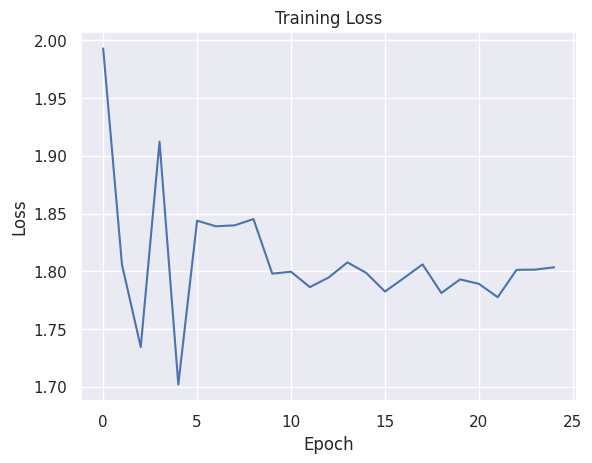

In [8]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

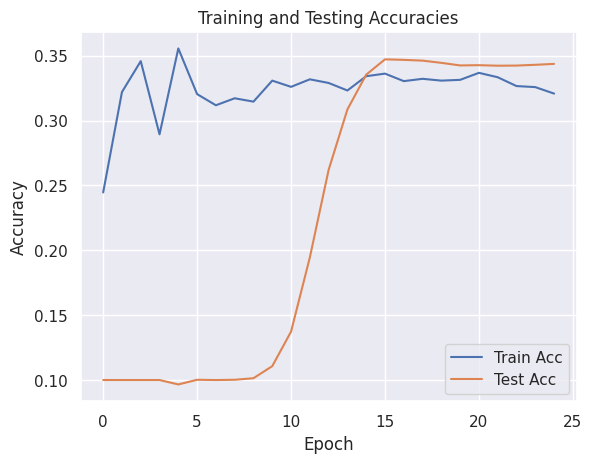

In [10]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.0, Accuracy: 34.369998931884766%
44.77 MB
CPU Inference Latency: 7.22 ms / sample
CUDA Inference Latency: 7.52 ms / sample


In [12]:
save_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')

In [13]:
pass